In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('final_cleaned.csv')
df.head()

,date,day_of_week,hour_of_day,is_weekend,temperature,is_holiday,solar_generation,electricity_demand,is_summer,is_winter,is_monsoon
0,2000-01-01,5,0,1,17.483571,0,0.853473,512.319382,0,1,0
1,2000-01-01,5,1,1,14.308678,0,4.869377,439.055673,0,1,0
2,2000-01-01,5,2,1,18.238443,0,4.997991,539.090652,0,1,0
3,2000-01-01,5,3,1,22.615149,0,2.738188,523.248968,0,1,0
4,2000-01-01,5,4,1,13.829233,0,7.694527,516.822822,0,1,0


In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import joblib

In [4]:
df = pd.read_csv('final_cleaned.csv')

print("Columns in CSV:", df.columns)

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df.head()

Columns in CSV: Index(['date', 'day_of_week', 'hour_of_day', 'is_weekend', 'temperature',
       'is_holiday', 'solar_generation', 'electricity_demand', 'is_summer',
       'is_winter', 'is_monsoon'],
      dtype='object')


,day_of_week,hour_of_day,is_weekend,temperature,is_holiday,solar_generation,electricity_demand,is_summer,is_winter,is_monsoon
date,,,,,,,,,,
2000-01-01,5,0,1,17.483571,0,0.853473,512.319382,0,1,0
2000-01-01,5,1,1,14.308678,0,4.869377,439.055673,0,1,0
2000-01-01,5,2,1,18.238443,0,4.997991,539.090652,0,1,0
2000-01-01,5,3,1,22.615149,0,2.738188,523.248968,0,1,0
2000-01-01,5,4,1,13.829233,0,7.694527,516.822822,0,1,0


In [5]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

In [6]:
joblib.dump(scaler, 'scaler.save')

['scaler.save']

In [7]:
sequence_length = 24  
X, y = [], []

target_col = 'electricity_demand' 
target_idx = df.columns.get_loc(target_col)

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i, target_idx])

X, y = np.array(X), np.array(y)

print("X shape:", X.shape, "| y shape:", y.shape)

X shape: (210337, 24, 10) | y shape: (210337,)


In [8]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        71,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,689 (479.25 KB)

 Trainable params: 122,689 (479.25 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint('best_lstm_model.keras', save_best_only=True)
]


In [10]:
history = model.fit(
    X, y,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=callbacks
)

Epoch 1/50
5916/5916 ━━━━━━━━━━━━━━━━━━━━ 110s 18ms/step - loss: 0.0117 - mae: 0.0825 - val_loss: 0.0084 - val_mae: 0.0733
Epoch 2/50
5916/5916 ━━━━━━━━━━━━━━━━━━━━ 101s 17ms/step - loss: 0.0076 - mae: 0.0693 - val_loss: 0.0079 - val_mae: 0.0712
Epoch 3/50
5916/5916 ━━━━━━━━━━━━━━━━━━━━ 99s 17ms/step - loss: 0.0073 - mae: 0.0683 - val_loss: 0.0082 - val_mae: 0.0722
Epoch 4/50
5916/5916 ━━━━━━━━━━━━━━━━━━━━ 100s 17ms/step - loss: 0.0073 - mae: 0.0682 - val_loss: 0.0080 - val_mae: 0.0719
Epoch 5/50
5916/5916 ━━━━━━━━━━━━━━━━━━━━ 101s 17ms/step - loss: 0.0073 - mae: 0.0680 - val_loss: 0.0082 - val_mae: 0.0725
Epoch 6/50
5916/5916 ━━━━━━━━━━━━━━━━━━━━ 100s 17ms/step - loss: 0.0072 - mae: 0.0678 - val_loss: 0.0074 - val_mae: 0.0684
Epoch 7/50
5916/5916 ━━━━━━━━━━━━━━━━━━━━ 132s 22ms/step - loss: 0.0073 - mae: 0.0680 - val_loss: 0.0075 - val_mae: 0.0693
Epoch 8/50
5916/5916 ━━━━━━━━━━━━━━━━━━━━ 131s 22ms/step - loss: 0.0072 - mae: 0.0677 - val_loss: 0.0080 - val_mae: 0.0717
Epoch 9/50
5916/5

In [13]:
model.save('final_lstm_model.keras')
print("✅ Model and scaler saved successfully!")


✅ Model and scaler saved successfully!


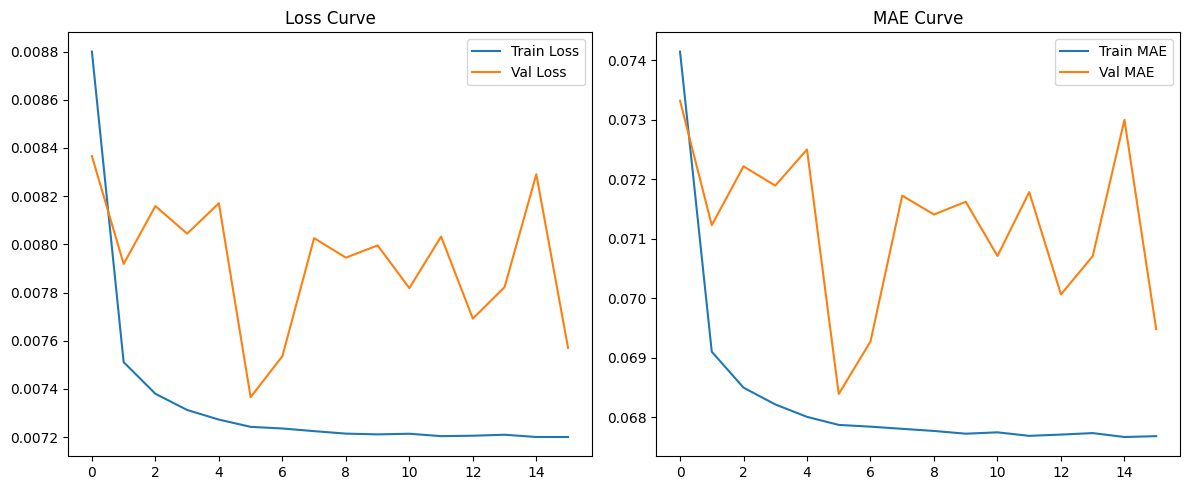

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE Curve')
plt.legend()

plt.tight_layout()
plt.show()

X_new shape for inference: (673, 24, 10)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
✅ Predictions saved to 'predicted_results.csv'


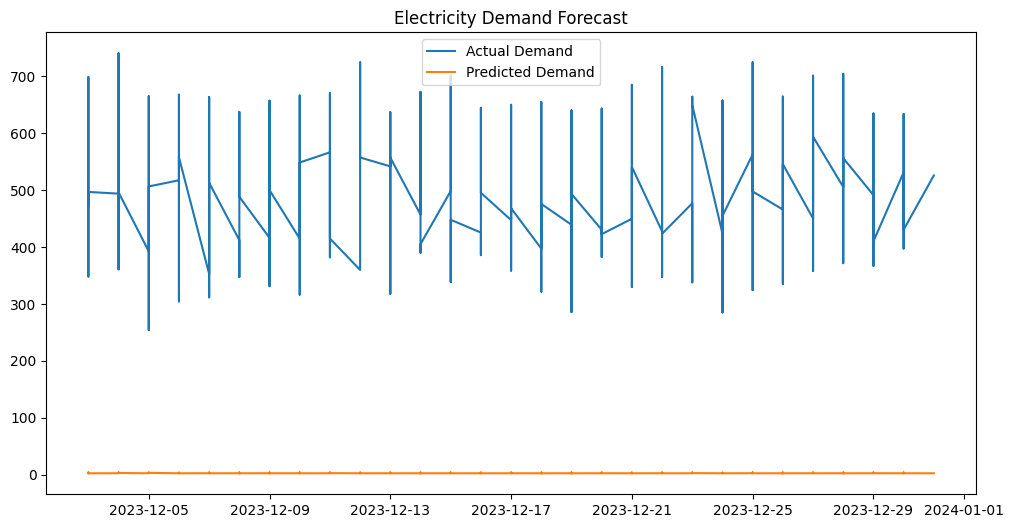

In [ ]:

import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model

new_df = pd.read_csv('new_data_simulated.csv')

new_df['date'] = pd.to_datetime(new_df['date'])
new_df.set_index('date', inplace=True)

scaler = joblib.load('scaler.save')
model = load_model('final_lstm_model.keras')

scaled_new_data = scaler.transform(new_df)

sequence_length = 24  # should match training value
X_new = []

for i in range(sequence_length, len(scaled_new_data)):
    X_new.append(scaled_new_data[i-sequence_length:i])

X_new = np.array(X_new)

print("X_new shape for inference:", X_new.shape)

predictions = model.predict(X_new)

real_demand_predictions = predictions * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]

result_df = new_df.iloc[sequence_length:].copy()
result_df['Predicted_electricity_demand'] = real_demand_predictions

result_df.to_csv('predicted_results.csv')
print("✅ Predictions saved to 'predicted_results.csv'")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(result_df.index, result_df['electricity_demand'], label='Actual Demand')
plt.plot(result_df.index, result_df['Predicted_electricity_demand'], label='Predicted Demand')
plt.legend()
plt.title('Electricity Demand Forecast')
plt.show()

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# 1. Load your dataset
df = pd.read_csv('final_cleaned.csv')

# 2. Define features and target
features = ['day_of_week', 'hour_of_day', 'is_weekend', 'temperature',
            'is_holiday', 'solar_generation', 'is_summer', 'is_winter', 'is_monsoon']
target = 'electricity_demand'

X = df[features]
y = df[target]

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Evaluate
y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

# 6. Save the trained model
joblib.dump(model, 'electricity_demand_model.pkl')
print("Model saved as electricity_demand_model.pkl")

MSE: 2705.703777358005
R2 Score: 0.6671367683123053
Model saved as electricity_demand_model.pkl


In [ ]:
import pandas as pd
import joblib

model = joblib.load('electricity_demand_model.pkl')
print("Model loaded successfully!")

new_data = pd.read_csv('new_data_simulated.csv')  

features = ['day_of_week', 'hour_of_day', 'is_weekend', 'temperature',
            'is_holiday', 'solar_generation', 'is_summer', 'is_winter', 'is_monsoon']

X_new = new_data[features]

new_data['predicted_demand'] = model.predict(X_new)

new_data.to_csv('new_data_with_predictions.csv', index=False)
print("Predictions saved to new_data_with_predictions.csv")

print(new_data[['date', 'hour_of_day', 'electricity_demand', 'predicted_demand']].head(10

Model loaded successfully!
Predictions saved to new_data_with_predictions.csv
         date  hour_of_day  electricity_demand  predicted_demand
0  2023-12-02           14          272.772568        323.876944
1  2023-12-02           15          512.590790        502.892869
2  2023-12-02           16          452.844217        430.151480
3  2023-12-02           17          488.870249        484.680059
4  2023-12-02           18          532.533179        545.072901
5  2023-12-02           23          494.293745        503.807363
6  2023-12-02           20          677.970501        666.487102
7  2023-12-02           21          578.102198        600.784560
8  2023-12-02           22          560.861060        588.478970
9  2023-12-02           13          456.082287        461.658987


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5259/5259 ━━━━━━━━━━━━━━━━━━━━ 4s 666us/step - loss: 0.0116 - val_loss: 0.0072
Epoch 2/50
5259/5259 ━━━━━━━━━━━━━━━━━━━━ 3s 559us/step - loss: 0.0070 - val_loss: 0.0063
Epoch 3/50
5259/5259 ━━━━━━━━━━━━━━━━━━━━ 3s 577us/step - loss: 0.0061 - val_loss: 0.0057
Epoch 4/50
5259/5259 ━━━━━━━━━━━━━━━━━━━━ 3s 555us/step - loss: 0.0058 - val_loss: 0.0056
Epoch 5/50
5259/5259 ━━━━━━━━━━━━━━━━━━━━ 3s 553us/step - loss: 0.0057 - val_loss: 0.0055
Epoch 6/50
5259/5259 ━━━━━━━━━━━━━━━━━━━━ 3s 558us/step - loss: 0.0056 - val_loss: 0.0055
Epoch 7/50
5259/5259 ━━━━━━━━━━━━━━━━━━━━ 3s 551us/step - loss: 0.0056 - val_loss: 0.0055
Epoch 8/50
5259/5259 ━━━━━━━━━━━━━━━━━━━━ 3s 552us/step - loss: 0.0056 - val_loss: 0.0055
Epoch 9/50
5259/5259 ━━━━━━━━━━━━━━━━━━━━ 3s 559us/step - loss: 0.0056 - val_loss: 0.0054
Epoch 10/50
5259/5259 ━━━━━━━━━━━━━━━━━━━━ 3s 549us/step - loss: 0.0056 - val_loss: 0.0055
Epoch 11/50
5259/5259 ━━━━━━━━━━━━━━━━━━━━ 4s 679us/step - loss: 0.0056 - val_loss: 0.0054
Epoch 12

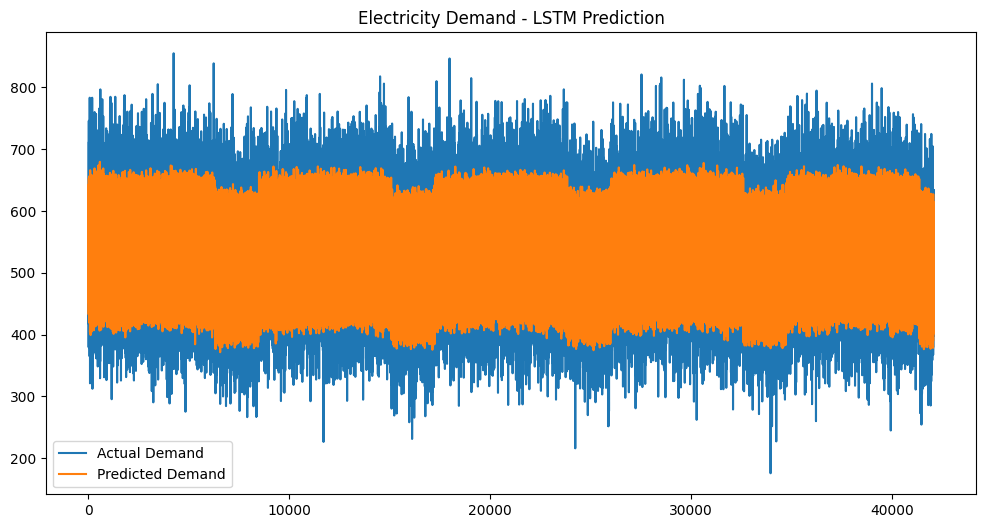

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

df = pd.read_csv("final_cleaned.csv")

features = ['day_of_week', 'hour_of_day', 'is_weekend', 'temperature', 
            'is_holiday', 'solar_generation', 'is_summer', 'is_winter', 'is_monsoon']
target = 'electricity_demand'

X = df[features]
y = df[[target]]

# Step 3: Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

model = Sequential()
model.add(LSTM(64, input_shape=(1, X_scaled.shape[2]), return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
print(f"LSTM MSE: {mse:.2f}")
print(f"LSTM R2 Score: {r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled, label="Actual Demand")
plt.plot(y_pred_rescaled, label="Predicted Demand")
plt.legend()
plt.title("Electricity Demand - LSTM Prediction")
plt.show()

model.save("lstm_electricity_model.h5")

#### GridSearchCV ( Full Grid + Learning Rate Tuner)

In [ ]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=128, step=32),
        return_sequences=False,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))
    model.add(Dense(1))
    
    # Tune learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='mse')
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=15,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='electricity_demand_tuning'
)

tuner.search(X_train, y_train, epochs=20, validation_split=0.2)


best_model = tuner.get_best_models(num_models=1)[0]

Trial 15 Complete [00h 01m 22s]
val_loss: 0.007113663945347071

Best val_loss So Far: 0.0057474770583212376
Total elapsed time: 00h 15m 59s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
import requests

def get_weather():
    API_KEY = "6eadd6b200966fdf87f6893823370e56"
    CITY = "New Delhi"
    url = f"http://api.weatherstack.com/current?access_key={API_KEY}&query={CITY}"
    response = requests.get(url).json()
    return {
        'temperature': response['current']['temperature'],
        'humidity': response['current']['humidity'],
        'wind_speed': response['current']['wind_speed']
    }

weather = get_weather()

{'temperature': 23, 'humidity': 14, 'wind_speed': 6}


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import joblib

model = tf.keras.models.load_model(
    'lstm_electricity_model.h5',
    custom_objects={'mse': tf.keras.losses.MeanSquaredError()}
)
print("✅ Model loaded successfully!")

scaler_X = joblib.load('scaler_X.pkl')  # scaler for features
scaler_y = joblib.load('scaler_y.pkl')  # scaler for target

new_data = pd.read_csv('new_data_simulated.csv')
features = ['day_of_week', 'hour_of_day', 'is_weekend', 'temperature',
            'is_holiday', 'solar_generation', 'is_summer', 'is_winter', 'is_monsoon']

X_new = new_data[features]
X_new_scaled = scaler_X.transform(X_new)
X_new_scaled = X_new_scaled.reshape((X_new_scaled.shape[0], 1, X_new_scaled.shape[1]))

y_pred_scaled = model.predict(X_new_scaled)

y_pred = scaler_y.inverse_transform(y_pred_scaled)

new_data['predicted_demand'] = y_pred

new_data.to_csv('new_data_with_predictions.csv', index=False)
print("✅ Predictions saved to new_data_with_predictions.csv")

print(new_data[['date', 'hour_of_day', 'predicted_demand']].head(10))

✅ Model loaded successfully!
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
✅ Predictions saved to new_data_with_predictions.csv
         date  hour_of_day  predicted_demand
0  2023-12-02           14        405.073425
1  2023-12-02           15        477.038971
2  2023-12-02           16        415.194122
3  2023-12-02           17        492.317169
4  2023-12-02           18        573.990295
5  2023-12-02           23        496.928558
6  2023-12-02           20        633.535767
7  2023-12-02           21        613.692322
8  2023-12-02           22        608.270508
9  2023-12-02           13        500.886017
